## 2 - Plate Reconstructions

In this notebook, we will explore GPlately functionalities for setting up and using a plate reconstruction model. Here, we detail how GPlately's `PlateReconstruction` object can be used to:

- Construct a plate motion model;
- Tessellate subduction zones & mid-ocean ridges; and
- Reconstruct feature geometries

The `PlateReconstruction` object contains methods to reconstruct topology features at a specific geological time. All you need to do to use this object is provide a rotation model, topology features (or feature collection) and a set of static polygons. 

To see this in action, let's first initialise all needed packages.

In [2]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

We generate a plate reconstruction model using data from a study by Muller et al. (2019) (Source: https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/). 

The `DataServer` object on GPlately's `data` module can be used to download data on-the-fly and store them in your system's local cache - you won't need to have local copies of files to point to anymore!

Given:
- a download URL to a zip file containing your needed data; and 
- a specific file extension to extract (i.e. ".rot" or ".gpml") 

..the modules in `DataServer` return the complete paths to your needed files as strings in a list. We can use these cached files for all other GPlately functionalities in the same way we'd use local copies of them. 

Here, we use the URL to the Muller et al. (2019) zip file `zip_url = "https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics.zip"
` and `.rot` and `.gpml` file extensions with GPlately's `fetch_filenames` method to get the Muller et al. (2019) rotation model and topology features, respectively. 

We use `fetch_static_polygons` with the `.shp` file extension to get the Muller et al. (2019) static polygons.

Let's call the `DataServer` object `gfetch`.

In [3]:
# Initialise gplately data server
gfetch = gplately.data.DataServer()

# We want Muller et al. (2019) data
zip_url = "https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics.zip"

# Get the rotation model and topologies 
rot_ext = ".rot"
rotation_filenames = gfetch.fetch_filenames(zip_url, rot_ext)
rotation_model = pygplates.RotationModel(rotation_filenames)

gpml_ext = ".gpml"
topology_filenames = gfetch.fetch_filenames(zip_url, gpml_ext)
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Get the static polygons
stat_poly_ext = ".shp"
static_polygons = gfetch.fetch_static_polygons(zip_url, stat_poly_ext)


### Constructing a plate motion model using the `PlateReconstruction` object

Once the rotation model, topology features and static polygons have been initialised, you can simply supply them to the `PlateReconstruction` object to construct the plate motion model.

In [4]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

### Reconstructing feature geometries

The plate motion model we created can be used to generate plate reconstructions through geological time. Let's reconstruct subduction zones and mid-ocean ridges to 50 Ma.

In [5]:
time = 50 #Ma
subduction_data = model.tesselate_subduction_zones(time)
ridge_data = model.tesselate_mid_ocean_ridges(time)

As a quick aside, you can visualise this data on a GeoAxis plot using the `PlotTopologies` object in `Plot`, which is another GPlately module. All you need to do to use this object is supply the `PlateReconstruction` plate motion model we just created along with a specific reconstruction time (Ma). 

To see these subduction and MOR boundaries clearly, let's plot them with coastlines, continents and continent-ocean boundaries (COBs). You can obtain paths to files containing these features with GPlately's `DataServer` object too. We'll use the same Muller et al. (2019) zip file download link and  the ".shp" extension for these files. 

Along with the plate motion model and reconstruction time, these shapefile paths are also main attributes of the `PlotTopologies` object.

Let's call the `PlotTopologies` object 'gplot'.

In [7]:
# Obtain geometry shapefiles with fetcher
zip_url = "https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tectonics/Muller_etal_2019_PlateMotionModel/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics.zip"
shp_ext = ".shp"
coastlines = gfetch.fetch_coastlines(zip_url, shp_ext)
continents = gfetch.fetch_continents(zip_url, shp_ext)
COBs = gfetch.fetch_COBs(zip_url, shp_ext)

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

To plot using GPlately's `PlotTopologies` object, first create a GeoAxis plot and select a projection using Cartopy. This is the plot we supply to our gplot object.

Now, let's visualise how the subduction zones (with subduction teeth!) and mid-ocean ridges look like at 50 Ma. 

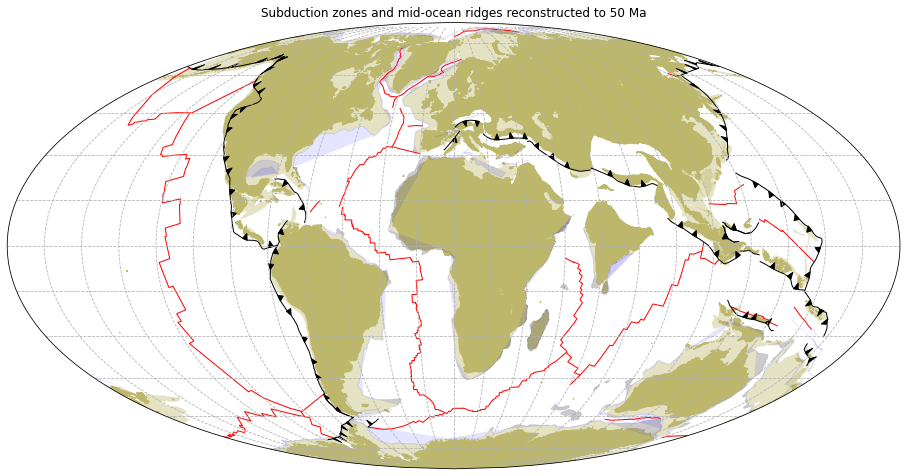

In [9]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = 50 # Ma
gplot.plot_continents(ax, facecolor='DarkKhaki', alpha=0.4)
gplot.plot_coastlines(ax, color='DarkKhaki')
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.1)
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')

If you have moviepy available, you can create a gif that illustrates plate motions through geological time. Let's reconstruct plate movements up to 100 Ma in intervals of 10 Ma!

In [10]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    print(f'working on time {time}')
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

    # Update the reconstruction time to allocate to gplot
    gplot.time = time
    
    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.plot_continents(ax, facecolor='DarkKhaki', alpha=0.4)
    gplot.plot_coastlines(ax, color='DarkKhaki')
    gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.1)
    gplot.plot_ridges_and_transforms(ax, color='red')
    gplot.plot_trenches(ax, color='k')
    gplot.plot_subduction_teeth(ax, color='k')
    
    plt.savefig('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

working on time 100.0
Image for 100 Ma saved
working on time 90.0
Image for 90 Ma saved
working on time 80.0
Image for 80 Ma saved
working on time 70.0
Image for 70 Ma saved
working on time 60.0
Image for 60 Ma saved
working on time 50.0
Image for 50 Ma saved
working on time 40.0
Image for 40 Ma saved
working on time 30.0
Image for 30 Ma saved
working on time 20.0
Image for 20 Ma saved
working on time 10.0
Image for 10 Ma saved


In [11]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/subd_mor_boundary_features.gif')

MoviePy - Building file /tmp/subd_mor_boundary_features.gif with imageio.


The movie will show up in a few seconds. Please be patient...


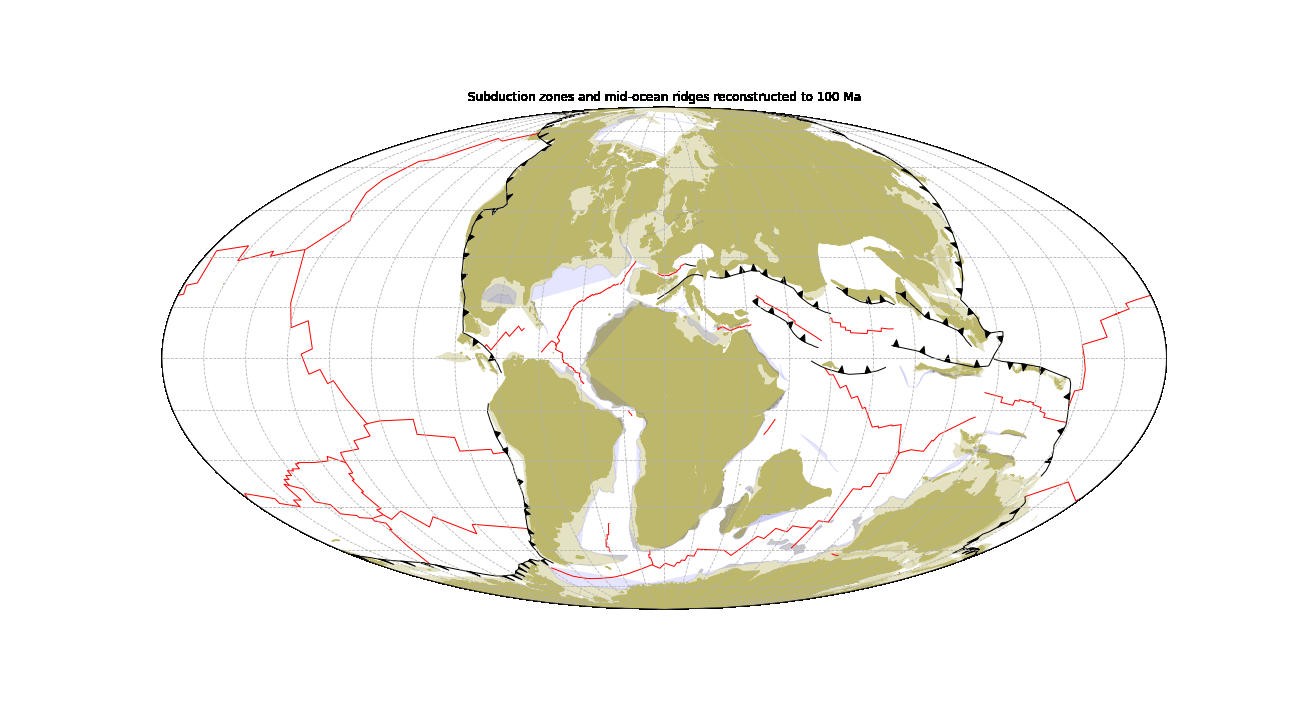

In [12]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/subd_mor_boundary_features.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 500))